# Code to analyse usage BCD

1 March 2021 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mannwhitneyu
from scipy.stats import wilcoxon as wilcoxon

In [2]:
# read usage BCD
def read_usage():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/Usage_BCD_CROS.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, header=0, nrows=85)
    df = df.drop(['Unnamed: 0', 'Average_use_CROS'], axis=1)
    df = df.fillna(pd.NA)
    return df

In [3]:
df = read_usage()
df_usage = df.drop(columns='Study_ID') # drop first column
df_usage = df_usage.dropna(axis='index')
type_device = df_usage.pop('Device')
df_usage = df_usage.astype('float64')    # change numeric data to type float, because of objects
df_usage.insert(0, 'Device', type_device)
df_usage

,Device,Average_use_BCD
0,BP110,0.1
1,BP110,1.4
2,BP110,0.4
3,BP110,1.0
4,BP110,1.4
...,...,...
80,BAHA5P,3.9
81,BAHA5P,0.6
82,BAHA5P,0.3
83,BAHA5P,1.1


In [4]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc_usage = df_usage.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc_usage.quantile(q=quantiles)
q

Average_use_BCD
Device                     
BAHA5P 0.1             0.10
       0.5             1.20
       0.9             4.80
BP110  0.1             0.10
       0.5             0.70
       0.9             4.96

In [5]:
# rearranging the datafame with quantiles
q= q.round(decimals=1)
q.reset_index(drop=True, inplace=True)
diq = {0:'BAHA5P P10', 1:'BAHA5P P50', 2:'BAHA5P P90', 
      3:'BP110 P10', 4:'BP110 P50', 5:'BP110 P90'} 

q = q.rename(index=diq)
q

,Average_use_BCD
BAHA5P P10,0.1
BAHA5P P50,1.2
BAHA5P P90,4.8
BP110 P10,0.1
BP110 P50,0.7
BP110 P90,5.0


In [6]:
# select BP110 data and convert the Pandas Dataframe to numpy array
is_bp110 =  df_usage['Device']=='BP110'
usage_bp110 = df_usage[is_bp110]
dvc1 = usage_bp110.pop('Device')
bp110 = usage_bp110.T.to_numpy()

usage_bp110.shape

(47, 1)

In [7]:
# select BAHA5P data and convert the Pandas Dataframe to numpy array
is_baha5p =  df_usage['Device']=='BAHA5P'
usage_baha5p = df_usage[is_baha5p]
dvc2 = usage_baha5p.pop('Device')
bh5 = usage_baha5p.T.to_numpy()

usage_baha5p.shape

(31, 1)

In [8]:
# compare distribution of Usage between groups BP110 & BAHA5P with Mann Whitney U test
d1 = dict()
d2 = dict()
for i in range(0, 1):
    (stat, pvalue) = mannwhitneyu(bp110[i], bh5[i], use_continuity=False, alternative='two-sided')
    d1.update({i : stat})
    d2.update({i : pvalue})

In [9]:
mwu = pd.DataFrame.from_dict([d1, d2])
rws = {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
clmns = {0 : 'Average_use_BCD'}
mwu.rename(index = rws, columns = clmns, inplace = True)
mwu = mwu.round(decimals=4)
mwu

,Average_use_BCD
Mann-Whitney U statistic,631.5000
p-value (two-sided),0.3214


In [10]:
analysis_res = pd.concat([q, mwu])
analysis_res = analysis_res.round(decimals=3)
analysis_res

,Average_use_BCD
BAHA5P P10,0.100
BAHA5P P50,1.200
BAHA5P P90,4.800
BP110 P10,0.100
BP110 P50,0.700
BP110 P90,5.000
Mann-Whitney U statistic,631.500
p-value (two-sided),0.321


In [11]:
both_types = np.concatenate((bp110, bh5), axis=1)

In [12]:
# perform calculation of quantiles 10, 50, 90 for all devices
bt = pd.DataFrame(both_types)
bt = bt.T
quantiles = [0.10, 0.50, 0.90]
q = bt.quantile(q=quantiles)
q

,0
0.1,0.10
0.5,1.05
0.9,4.92


In [13]:
# write to xlsx file
analysis_res.to_excel("/media/guido/LACIE/Cingle_Guido/Analysis_results/analysis_usage_BCD_vs_CROS.xlsx",
                         sheet_name='analysis_usage_BCD')  

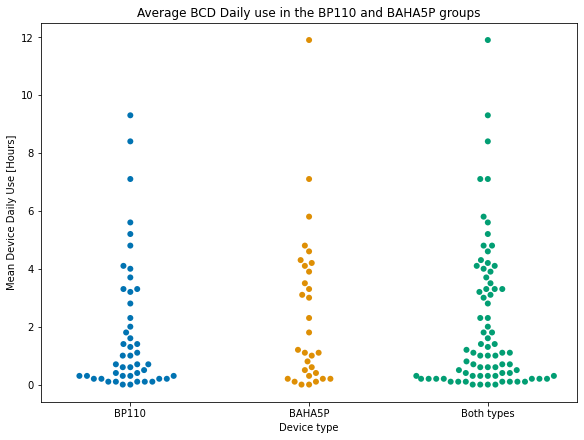

In [14]:
# make a figure to plot the usage of the 2 groups separetely and together
ttl = 'Average BCD Daily use in the BP110 and BAHA5P groups'

d = {'BP110' : bp110[0], 'BAHA5P' : bh5[0], 'Both types' : both_types[0]} 

pp = pd.DataFrame.from_dict(d, orient='index')
pp = pp.transpose()
tp = pd.melt(pp, var_name = 'Device type', value_name = 'Mean Device Daily Use [Hours]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(6)
fig.set_figwidth(8)

ax = sns.swarmplot(data = tp, x = 'Device type', y = 'Mean Device Daily Use [Hours]', 
                   size=6, palette='colorblind')

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Analysis_results/usage_BCD.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()